In [1]:
# Parameters
galaxy_id = "g8.13e11"
pipeline_name = "calc_ifu"
telescope_name = "MUSE"


In [2]:
# Parameters
#galaxy_id = "g8.26e11"
#pipeline_name = "calc_ifu"
#telescope_name = "MUSE_test"

In [3]:
# NBVAL_SKIP
import os
os.environ['SPS_HOME'] = '/mnt/storage/annalena_data/sps_fsps'
#os.environ['SPS_HOME'] = '/home/annalena/sps_fsps'
#os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'
os.environ['SPS_HOME'] = '/home/annalena_data/sps_fsps'

# Fits files

In this notebook we show, how you can store your mock datacube in a fits file, which is the common format in which are observational data handled. We firtss create a mock IFU cube by running the RUBIX pipeline, store it then in a fits file and then lod the data from the fits file.

In [4]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
import os
from rubix.core.pipeline import RubixPipeline

# Define NIHAO configuration
config_illustris = {
    "pipeline": {"name": pipeline_name},
    "logger": {"log_level": "DEBUG", "log_file_path": None, "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"},
    "data": {
        "name": "NihaoHandler",
        "args": {
            "particle_type": ["stars", "gas"],
            "save_data_path": "data",
            "snapshot": "1024",
        },
        "load_galaxy_args": {"reuse": True, "id": galaxy_id},
        "subset": {"use_subset": True, "subset_size": 100},
    },
    "simulation": {
        "name": "NIHAO",
        "args": {
            "path": f'/home/_data/nihao/nihao_classic/{galaxy_id}/{galaxy_id}.01024',
            "halo_path": f'/home/_data/nihao/nihao_classic/{galaxy_id}/{galaxy_id}.01024.z0.000.AHF_halos',
            "halo_id": 0,
        },
    },
    "output_path": "output",
    "telescope": {"name": telescope_name,
                  "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
                  "lsf": {"sigma": 1.2},
                  "noise": {"signal_to_noise": 100, "noise_distribution": "normal"}},
    "cosmology": {"name": "PLANCK15"},
    "galaxy": {"dist_z": 0.01, "rotation": {"type": "edge-on"}}, #{"alpha": 90.0, "beta": 0.0, "gamma":0.0}},
    "ssp": {"template": {"name": "FSPS"},
            "dust": {
                "extinction_model": "Cardelli89",
                "dust_to_gas_ratio": 0.01,
                "dust_to_metals_ratio": 0.4,
                "dust_grain_density": 3.5,
                "Rv": 3.1,
            },
    },
}

# Run pipeline
pipe = RubixPipeline(config_illustris)
data = pipe.run()

2025-05-20 01:14:26,707 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-05-20 01:14:26,708 - rubix - INFO - Rubix version: 0.0.post419+g51d0ee9
2025-05-20 01:14:26,708 - rubix - INFO - JAX version: 0.6.0
2025-05-20 01:14:26,709 - rubix - INFO - Running on [CpuDevice(id=0)] devices
/home/annalena/.conda/envs/rubix/lib/python3.11/site-packages/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /home/annalena/.conda/envs/rubix/lib/python3.11/site-packages/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-05-20 01:14:27,015 - rubix - INFO - Getting rubix data...
2025-05-20 01:14:27,016 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2025-05-20 01:14:27,072 - rubix - INFO - Centering stars particles
2025-05-20 01:14:28,411 - rubix - WARNING - The Subset value is set in config. Using only subset of size 100 for stars
2025-05-20 01:

## Convert luminosity to flux

In [5]:
from rubix.spectra.ifu import convert_luminoisty_to_flux
from rubix.cosmology import PLANCK15

observation_lum_dist = PLANCK15.luminosity_distance_to_z(config_illustris["galaxy"]["dist_z"])
observation_z = config_illustris["galaxy"]["dist_z"]
pixel_size = 1.0
fluxcube = convert_luminoisty_to_flux(data.stars.datacube, observation_lum_dist, observation_z, pixel_size)
data.stars.datacube = fluxcube/1e-20


# Store datacube in a fits file with header

In RUBIX we implemented a function that automaticly takes the relevant information from the config and writes it into the header. Then the header and data are stored in a fits file. All is done with the store_fits function from the rubix.core.fits module.

In [6]:
#NBVAL_SKIP
from rubix.core.fits import store_fits

#if config_illustris["telescope"]["name"] == "MUSE_ultraWFM":
#    cutted_datatcube = data.stars.datacube[300:600, :, :]
#    data.stars.datacube = cutted_datatcube
#if config_illustris["telescope"]["name"] == "MUSE_WFM":
#    cutted_datatcube = data.stars.datacube[100:200, :, :]
#    data.stars.datacube = cutted_datatcube

store_fits(config_illustris, data, "./output/")

/home/annalena/.conda/envs/rubix/lib/python3.11/site-packages/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /home/annalena/.conda/envs/rubix/lib/python3.11/site-packages/rubix/telescope/telescopes.yaml
  warnings.warn(


KeyError: 'alpha'

In [ ]:
#import pickle
#with open(f"output/datacube_NIHAO{config_illustris["data"]["load_galaxy_args"]["id"]}_{config_illustris["telescope"]["name"]}_{config_illustris["pipeline"]["name"]}.pkl", "wb") as f:
#    pickle.dump(data, f)

-48232320.0 24960406.0


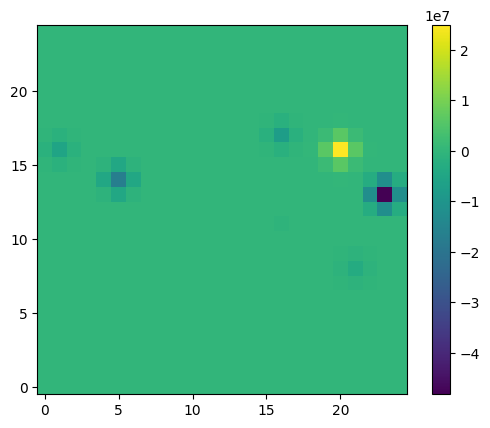

In [7]:
#NBVAL_SKIP
datacube = data.stars.datacube

img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")
#plt.plot(12,12, 'ro')
#plt.plot(17,12, 'x', color="blue")
#plt.plot(7,12, 'x', color="orange")
plt.colorbar()
print(img.min(), img.max())
#storepath = f"./output/datacube_NIHAO{config_illustris['data']['load_galaxy_args']['id']}_{config_illustris["telescope"]["name"]}_{config_illustris['pipeline']['name']}_fluxsum.png"
#plt.savefig(storepath)
plt.show()

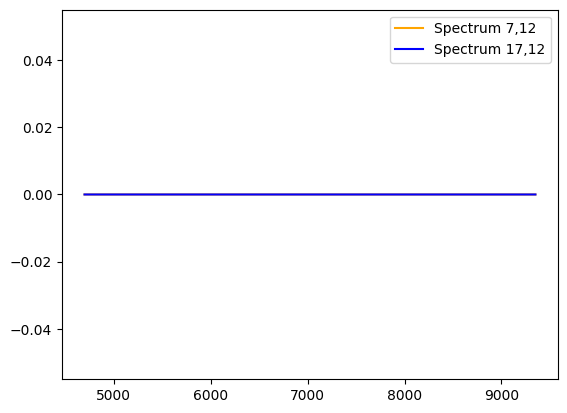

In [8]:
# NBVAL_SKIP
wave = pipe.telescope.wave_seq
#plt.plot(wave, data.stars.datacube[12, 12, :], color="red", label="Spectrum")
#plt.vlines(4861.333, 0, 3000, color='r', label="Hbeta=4861.333A")
#plt.vlines(4861.333*1.1, 0, 3000, color='y', label="line obs=Hbeta*(1+z)")
plt.plot(wave, data.stars.datacube[450, 450, :], color="orange", label="Spectrum 7,12")
plt.plot(wave, data.stars.datacube[17, 12, :], color="blue", label="Spectrum 17,12")
#plt.xlim(5300, 5400)
plt.legend()

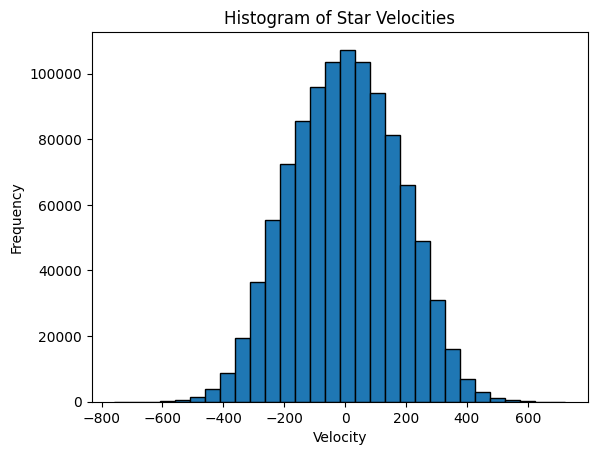

In [ ]:
# NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot a histogram of the velocities
plt.hist(data.stars.velocity[0,:,2], bins=30, edgecolor='black')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Star Velocities')
plt.show()

nan
nan


/tmp/ipykernel_346726/1051625039.py:14: RuntimeWarning: invalid value encountered in divide
  mean_velocity = sum_velocity / counts


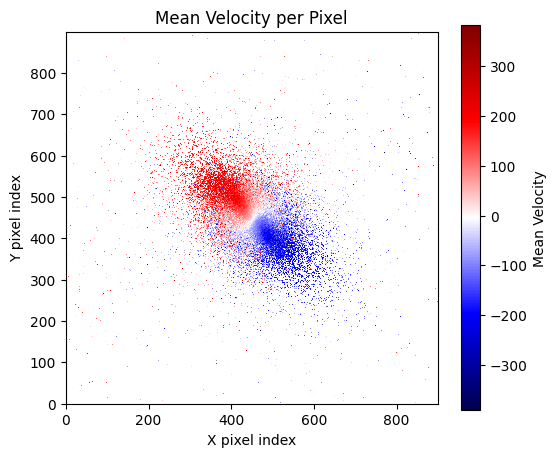

In [ ]:
# NBVAL_SKIP
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data arrays are defined as follows:
pixel_assignment = np.asarray(np.squeeze(data.stars.pixel_assignment))
velocities = np.asarray(data.stars.velocity[0, :, 2])

# Compute the sum of velocities and count per pixel using np.bincount
sum_velocity = np.bincount(pixel_assignment, weights=velocities)
counts = np.bincount(pixel_assignment)

# Calculate mean velocity; note: division by zero is avoided if every pixel has at least one star.
mean_velocity = sum_velocity / counts


# If you know the pixel grid dimensions (for example, a square grid)
n_pixels = len(mean_velocity)
grid_size = int(np.sqrt(n_pixels))
if grid_size * grid_size != n_pixels:
    raise ValueError("The total number of pixels is not a perfect square; please specify the grid shape explicitly.")

# Reshape the mean_velocity into a 2D array for imshow
velocity_map = mean_velocity.reshape((grid_size, grid_size))
print(velocity_map[12,12])

print(velocity_map[17,12]-velocity_map[7,12])
# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(velocity_map, origin='lower', interpolation='nearest', cmap='seismic')
plt.colorbar(label='Mean Velocity')
plt.title('Mean Velocity per Pixel')
plt.xlabel('X pixel index')
plt.ylabel('Y pixel index')
#storepath = f"./output/datacube_NIHAO{config_illustris['data']['load_galaxy_args']['id']}_{config_illustris["telescope"]["name"]}_{config_illustris['pipeline']['name']}_velocity.png"
#plt.savefig(storepath)
plt.show()

/tmp/ipykernel_346726/2500964597.py:14: RuntimeWarning: invalid value encountered in divide
  mean_age = sum_ages / counts


nan


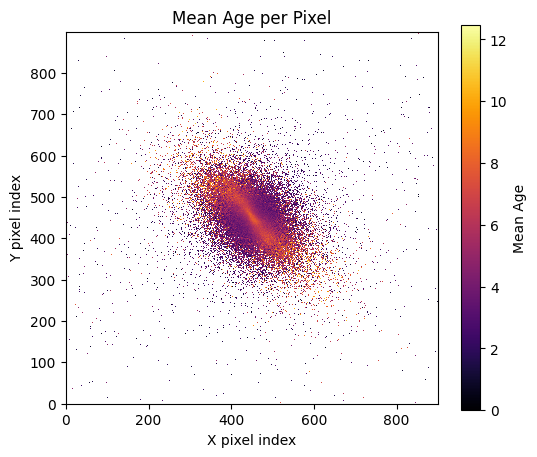

In [ ]:
# NBVAL_SKIP
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data arrays are defined as follows:
pixel_assignment = np.asarray(np.squeeze(data.stars.pixel_assignment))
ages = np.asarray(data.stars.age[0, :])

# Compute the sum of velocities and count per pixel using np.bincount
sum_ages = np.bincount(pixel_assignment, weights=ages)
counts = np.bincount(pixel_assignment)

# Calculate mean velocity; note: division by zero is avoided if every pixel has at least one star.
mean_age = sum_ages / counts


# If you know the pixel grid dimensions (for example, a square grid)
n_pixels = len(mean_age)
grid_size = int(np.sqrt(n_pixels))
if grid_size * grid_size != n_pixels:
    raise ValueError("The total number of pixels is not a perfect square; please specify the grid shape explicitly.")

# Reshape the mean_velocity into a 2D array for imshow
age_map = mean_age.reshape((grid_size, grid_size))
print(age_map[12,12])

# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(age_map, origin='lower', interpolation='nearest', cmap='inferno')
plt.colorbar(label='Mean Age')
plt.title('Mean Age per Pixel')
plt.xlabel('X pixel index')
plt.ylabel('Y pixel index')
#storepath = f"./output/datacube_NIHAO{config_illustris['data']['load_galaxy_args']['id']}_{config_illustris["telescope"]["name"]}_{config_illustris['pipeline']['name']}_age.png"
#plt.savefig(storepath)
plt.show()

0.0


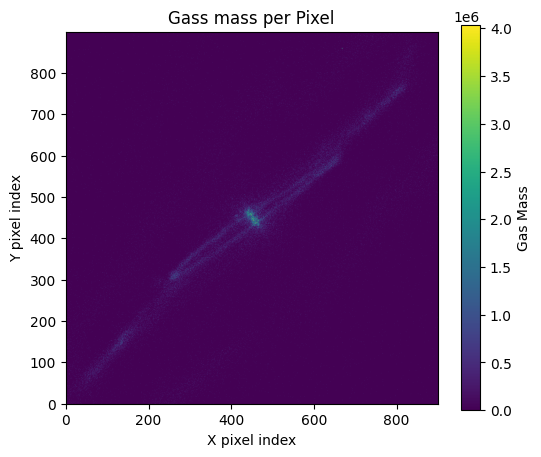

In [ ]:
# NBVAL_SKIP
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data arrays are defined as follows:
pixel_assignment = np.asarray(np.squeeze(data.gas.pixel_assignment))
gas_mass = np.asarray(data.gas.mass)

# Compute the sum of velocities and count per pixel using np.bincount
sum_gas_mass = np.bincount(pixel_assignment, weights=gas_mass[0,:])
counts = np.bincount(pixel_assignment)

# If you know the pixel grid dimensions (for example, a square grid)
n_pixels = len(sum_gas_mass)
grid_size = int(np.sqrt(n_pixels))
if grid_size * grid_size != n_pixels:
    raise ValueError("The total number of pixels is not a perfect square; please specify the grid shape explicitly.")

# Reshape the mean_velocity into a 2D array for imshow
gas_mass_map = sum_gas_mass.reshape((grid_size, grid_size))
print(gas_mass_map[12,12])

# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(gas_mass_map, origin='lower')
plt.colorbar(label='Gas Mass')
plt.title('Gass mass per Pixel')
plt.xlabel('X pixel index')
plt.ylabel('Y pixel index')
#storepath = f"./output/datacube_NIHAO{config_illustris['data']['load_galaxy_args']['id']}_{config_illustris["telescope"]["name"]}_{config_illustris['pipeline']['name']}_gasmass.png"
#plt.savefig(storepath)
plt.show()

0.0


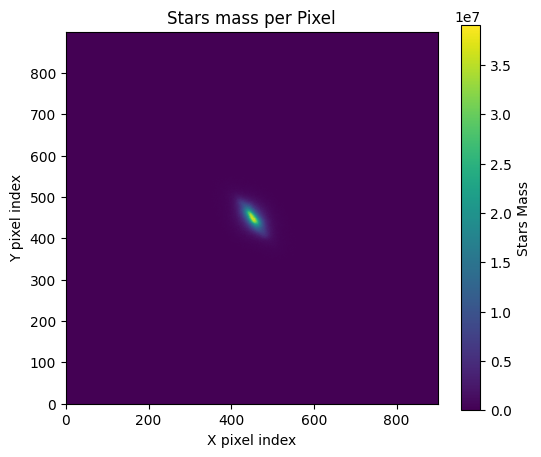

In [ ]:
# NBVAL_SKIP
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data arrays are defined as follows:
pixel_assignment = np.asarray(np.squeeze(data.stars.pixel_assignment))
stars_mass = np.asarray(data.stars.mass)

# Compute the sum of velocities and count per pixel using np.bincount
sum_stars_mass = np.bincount(pixel_assignment, weights=stars_mass[0,:])
counts = np.bincount(pixel_assignment)

# If you know the pixel grid dimensions (for example, a square grid)
n_pixels = len(sum_stars_mass)
grid_size = int(np.sqrt(n_pixels))
if grid_size * grid_size != n_pixels:
    raise ValueError("The total number of pixels is not a perfect square; please specify the grid shape explicitly.")

# Reshape the mean_velocity into a 2D array for imshow
stars_mass_map = sum_stars_mass.reshape((grid_size, grid_size))
print(stars_mass_map[12,12])

# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(stars_mass_map, origin='lower')
plt.colorbar(label='Stars Mass')
plt.title('Stars mass per Pixel')
plt.xlabel('X pixel index')
plt.ylabel('Y pixel index')
#storepath = f"./output/datacube_NIHAO{config_illustris['data']['load_galaxy_args']['id']}_{config_illustris["telescope"]["name"]}_{config_illustris['pipeline']['name']}_starsmass.png"
#plt.savefig(storepath)
plt.show()